In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score

In [6]:
def read_csv_from_link(url):
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    df = pd.read_csv(path,delimiter="\t",error_bad_lines=False, header=None)
    return df

In [33]:
# Data and Label Mapping
malayalam_train = read_csv_from_link('https://drive.google.com/file/d/13JCCr-IjZK7uhbLXeufptr_AxvsKinVl/view?usp=sharing')
malayalam_dev = read_csv_from_link('https://drive.google.com/file/d/1J0msLpLoM6gmXkjC6DFeQ8CG_rrLvjnM/view?usp=sharing')

# mal Preprocess
malayalam_train = malayalam_train.iloc[:, 0:2]
malayalam_train = malayalam_train.rename(columns={0: "text", 1: "label"})
# Stats
malayalam_train['label'] = pd.Categorical(malayalam_train.label)
# Mal Preprocess
malayalam_dev = malayalam_dev.iloc[:, 0:2]
malayalam_dev = malayalam_dev.rename(columns={0: "text", 1: "label"})
# Stats
malayalam_dev['label'] = pd.Categorical(malayalam_dev.label)


label_mapping = {
    'Not_offensive': 0, 
    'not-malayalam': 1, 
    'Offensive_Targeted_Insult_Group': 2, 
    'Offensive_Untargetede': 3, 
    'Offensive_Targeted_Insult_Individual': 4
}

dev_batch_labels =  [label_mapping[x] for x in malayalam_dev['label']]
target_names = label_mapping.keys()

In [30]:
import os
load_model_filenames = [x for x in os.listdir('./dev_probs/')]

In [31]:
# Read ALL fusion predictions models
load_model_filenames

['dev_preds_fusion_malayalam_XLMroberta_custom_pretrained_MalayalamXLMroberta_large_Malayalam_cnn_128.npy',
 '.ipynb_checkpoints',
 'dev_preds_fusion_malayalam_XLMroberta_base_MalayalamMbert_base_cased_Malayalam_cnn_128.npy',
 'dev_preds_fusion_malayalam_XLMroberta_base_Malayalam_cnn_128.npy',
 'dev_preds_fusion_malayalam_XLMroberta_base_MalayalamXLMroberta_large_MalayalamMbert_base_cased_Malayalam_cnn_128.npy',
 'dev_preds_fusion_malayalam_XLMroberta_custom_pretrained_MalayalamMbert_base_cased_Malayalam_cnn_128.npy',
 'dev_preds_fusion_malayalam_XLMroberta_base_MalayalamMbert_base_cased_Malayalam_.npy',
 'dev_preds_fusion_malayalam_XLMroberta_custom_pretrained_MalayalamXLMroberta_large_Tamil_cnn_128.npy']

In [32]:
all_dev_preds = []
all_dev_model_names = []
for modelname in load_model_filenames:
    if("ipynb" not in modelname):
        all_dev_model_names.append(modelname)
        all_dev_preds.append(np.load('./dev_probs/' + modelname))

In [35]:
# Collecting Text and Labels
dev_batch_sentences = list(malayalam_dev['text'])
dev_batch_labels =  [label_mapping[x] for x in malayalam_dev['label']]

for dev_preds, mn in zip(all_dev_preds, all_dev_model_names):
    final_dev_preds = np.argmax(dev_preds, axis = 1)
    y_true = dev_batch_labels
    y_pred = final_dev_preds
    target_names = label_mapping.keys()
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(mn)
    print(report)

dev_preds_fusion_malayalam_XLMroberta_custom_pretrained_MalayalamXLMroberta_large_Malayalam_cnn_128.npy
                                      precision    recall  f1-score   support

                       Not_offensive       0.98      0.99      0.99      1779
                       not-malayalam       0.90      0.93      0.92       163
     Offensive_Targeted_Insult_Group       0.82      0.69      0.75        13
               Offensive_Untargetede       0.93      0.70      0.80        20
Offensive_Targeted_Insult_Individual       0.93      0.58      0.72        24

                            accuracy                           0.97      1999
                           macro avg       0.91      0.78      0.83      1999
                        weighted avg       0.97      0.97      0.97      1999

dev_preds_fusion_malayalam_XLMroberta_base_MalayalamMbert_base_cased_Malayalam_cnn_128.npy
                                      precision    recall  f1-score   support

                     

In [ ]:
# Averaging Ensemble

In [36]:
all_dev_preds = np.array(all_dev_preds)

# Initialise Weights
w = np.ones(all_dev_preds.shape[0])
softmax_w = np.exp(w)/np.sum(np.exp(w))

weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

y_true = dev_batch_labels
y_pred = final_dev_preds
target_names = label_mapping.keys()
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

                                      precision    recall  f1-score   support

                       Not_offensive       0.98      0.99      0.98      1779
                       not-malayalam       0.91      0.91      0.91       163
     Offensive_Targeted_Insult_Group       0.82      0.69      0.75        13
               Offensive_Untargetede       0.87      0.65      0.74        20
Offensive_Targeted_Insult_Individual       0.93      0.58      0.72        24

                            accuracy                           0.97      1999
                           macro avg       0.90      0.77      0.82      1999
                        weighted avg       0.97      0.97      0.97      1999



In [ ]:
# GA-weighted ensemble

 The best solution found:                                                                           
 [3.80866039 0.83892262 4.44867459 1.13009363 3.57928917 1.20935295
 4.37148247]

 Objective function:
 0.15247926824237157


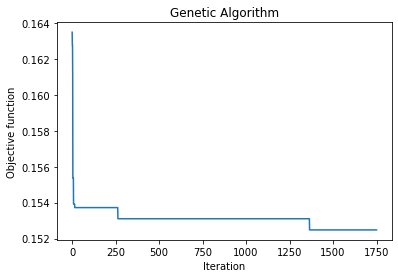

In [37]:
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    softmax_w = np.exp(X)/np.sum(np.exp(X))
    weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
    weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
    final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

    y_true = dev_batch_labels
    y_pred = final_dev_preds
    score = f1_score(y_true, y_pred, average='macro')
    return 1-score

varbound=np.array([[0, 5]]*all_dev_preds.shape[0])

model=ga(function=f,dimension=all_dev_preds.shape[0],variable_type='real',variable_boundaries=varbound)

model.run()

In [38]:
convergence=model.report
solution=model.output_dict

X = solution['variable']
softmax_w = np.exp(X)/np.sum(np.exp(X))
weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

y_true = dev_batch_labels
y_pred = final_dev_preds
target_names = label_mapping.keys()
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)
f1_score(y_true, y_pred, average='macro')

                                      precision    recall  f1-score   support

                       Not_offensive       0.98      0.99      0.99      1779
                       not-malayalam       0.93      0.93      0.93       163
     Offensive_Targeted_Insult_Group       0.90      0.69      0.78        13
               Offensive_Untargetede       1.00      0.70      0.82        20
Offensive_Targeted_Insult_Individual       0.93      0.58      0.72        24

                            accuracy                           0.98      1999
                           macro avg       0.95      0.78      0.85      1999
                        weighted avg       0.98      0.98      0.98      1999



0.8475207317576284

In [2]:
model_pretrained_keys = ['']*8  # NOT REQUIRED

In [40]:
saved_model_filename = 'self_ensemble_malayalam'

a = {x:(y,z) for x, y, z in zip(load_model_filenames, np.array(solution['variable']), model_pretrained_keys)}
import pickle
with open("/home/punyajoy/Dravidian_Offensive_Classification/dev_preds/weights_" + saved_model_filename + ".pickle", 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# Test With Labels
tamil_test = read_csv_from_link('https://drive.google.com/file/d/10RHrqXvIKMdnvN_tVJa_FAm41zaeC8WN/view?usp=sharing')
malayalam_test = read_csv_from_link('https://drive.google.com/file/d/1zx1wCC9A-Pp80mzbqixb52WlWQQ7ATyJ/view?usp=sharing')
kannada_test = read_csv_from_link('https://drive.google.com/file/d/1Px2CvIkLP_xaNhz_fCofW-7GGBCnSYsa/view?usp=sharing')

# Mal Preprocess
malayalam_test = malayalam_test.iloc[:, 0:2]
malayalam_test = malayalam_test.rename(columns={0: "text", 1: "label"})

b'Skipping line 778: expected 2 fields, saw 3\n'


In [9]:
malayalam_test.shape

(2001, 2)

In [65]:
malayalam_dev.shape

(1999, 2)

In [44]:
import pickle
saved_model_filename = 'self_ensemble_malayalam'

with open("/home/punyajoy/Dravidian_Offensive_Classification/dev_preds/weights_" + saved_model_filename + ".pickle", 'rb') as handle:
    mw = pickle.load(handle)

In [11]:
import os
load_model_filenames = [x for x in os.listdir('/home/punyajoy/Dravidian_Offensive_Classification/finetuning/malayalam_ft/test_probs/')]

In [24]:
all_test_preds = []
all_model_names = []
for modelname in load_model_filenames:
    if("ipynb" not in modelname):
        a = np.load('/home/punyajoy/Dravidian_Offensive_Classification/finetuning/malayalam_ft/test_probs/' + modelname)
        all_test_preds.append(a)
        all_model_names.append(modelname)
        print(a.shape,modelname)

(2001, 5) test_preds_fusion_malayalam_XLMroberta_base_Malayalam_cnn_128.npy
(2001, 5) test_preds_fusion_malayalam_XLMroberta_custom_pretrained_MalayalamMbert_base_cased_Malayalam_cnn_128.npy
(2001, 5) test_preds_fusion_malayalam_XLMroberta_base_MalayalamXLMroberta_large_MalayalamMbert_base_cased_Malayalam_cnn_128.npy
(2001, 5) test_preds_fusion_malayalam_XLMroberta_custom_pretrained_MalayalamXLMroberta_large_Malayalam_cnn_128.npy
(2001, 5) test_preds_fusion_malayalam_XLMroberta_base_MalayalamMbert_base_cased_Malayalam_cnn_128.npy
(2001, 5) test_preds_fusion_malayalam_XLMroberta_base_MalayalamMbert_base_cased_Malayalam_.npy


In [26]:
all_test_preds[0].shape

(2001, 5)

In [27]:
all_model_names

['test_preds_fusion_malayalam_XLMroberta_base_Malayalam_cnn_128.npy',
 'test_preds_fusion_malayalam_XLMroberta_custom_pretrained_MalayalamMbert_base_cased_Malayalam_cnn_128.npy',
 'test_preds_fusion_malayalam_XLMroberta_base_MalayalamXLMroberta_large_MalayalamMbert_base_cased_Malayalam_cnn_128.npy',
 'test_preds_fusion_malayalam_XLMroberta_custom_pretrained_MalayalamXLMroberta_large_Malayalam_cnn_128.npy',
 'test_preds_fusion_malayalam_XLMroberta_base_MalayalamMbert_base_cased_Malayalam_cnn_128.npy',
 'test_preds_fusion_malayalam_XLMroberta_base_MalayalamMbert_base_cased_Malayalam_.npy']

In [28]:
# Collecting Text and Labels
test_batch_sentences = list(malayalam_test['text'])
test_batch_labels =  [label_mapping[x] for x in malayalam_test['label']]

for test_preds, mn in zip(all_test_preds, all_model_names):
    final_test_preds = np.argmax(test_preds, axis = 1)
    y_true = test_batch_labels
    y_pred = final_test_preds
    target_names = label_mapping.keys()
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(mn)
    print(report)

test_preds_fusion_malayalam_XLMroberta_base_Malayalam_cnn_128.npy
                                      precision    recall  f1-score   support

                       Not_offensive       0.97      0.99      0.98      1765
                       not-malayalam       0.93      0.90      0.92       157
     Offensive_Targeted_Insult_Group       0.87      0.57      0.68        23
               Offensive_Untargetede       0.74      0.69      0.71        29
Offensive_Targeted_Insult_Individual       0.88      0.56      0.68        27

                            accuracy                           0.97      2001
                           macro avg       0.88      0.74      0.80      2001
                        weighted avg       0.97      0.97      0.97      2001

test_preds_fusion_malayalam_XLMroberta_custom_pretrained_MalayalamMbert_base_cased_Malayalam_cnn_128.npy
                                      precision    recall  f1-score   support

                       Not_offensive       0.

In [3]:
# GENERATE FINAL ENSEMBLED PREDICTIONS

In [69]:
weights = [mw[index][0] for index in mw.keys()]
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

X = weights
all_dev_preds = np.array(all_test_preds)


softmax_w = np.exp(X)/np.sum(np.exp(X))
weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

final_dev_pred_labels = [inverse_label_mapping[int(k)] for k in final_dev_preds]
saved_model_filename = 'test_GA_fusion_malayalam'
malayalam_test['labels'] = final_dev_pred_labels
malayalam_test.index.name = 'id'
malayalam_test.to_csv("/home/punyajoy/Dravidian_Offensive_Classification/test_preds/" + saved_model_filename + ".tsv", sep = '\t')

In [70]:
np.save("/home/punyajoy/Dravidian_Offensive_Classification/model_prediction_probs/"+'GA_fusion_malayalam'+".npy", weighted_dev_preds)